# CLASSIFICATION - SOFTMAX IMPLEMENTATION
Zaimplementować funkcję softmax dla warstwy wyjściowej sieci neuronowej. Sprawdzić szybkość i skuteczność w wariancie, gdy sieć używa funkcji softmax na ostatniej warstwie i gdy jest użyta zwykła funkcja aktywacji. Softmax wymaga też odpowiednich zmian w algorytmie uczenia, uwzględniających pochodną fukcji.

Przeprowadzić eksperymenty na zbiorach (w nawiasach wymagana wartość F-measure na 2 punkty):

rings3-regular (F-measure: 0.75),  
easy (F-measure: 0.99),  
xor3 (F-measure: 0.97)

https://www.mldawn.com/back-propagation-with-cross-entropy-and-softmax/?fbclid=IwAR2lw823lMFt5f3wFr962Uary-omGz6u_zbwU3fP3tBZXvEG_tJ7Nr-BaEc

In [43]:
import pandas as pd
import numpy as np
from numpy import dot, square, subtract
from scipy.special import expit
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

np.random.seed(420)

In [44]:
def softmax(x): #https://stackoverflow.com/questions/42599498/numerically-stable-softmax
    x = x-x.max(axis=1).reshape(-1,1) # softmax(x) = softmax(x+c)
    return np.exp(x) / np.exp(x).sum(axis=1).reshape(-1,1)


def softmax_der(x):
    I = np.eye(x.shape[0])
    return softmax(x) * (I - softmax(x).T)


def cross_E(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 10**-10))


def one_hot(x):
    vals = np.unique(x)
    tmp = []
    for val in vals:
        tmp += [((x==val)*1).tolist()]
    return(np.array(tmp))

In [45]:
class MLP():
    def __init__(self, neurons, activation='sigmoid', activation_out='linear'):
        self.neurons = neurons
        self.weights = []
        self.biases = []
        self.activation = self.activ[activation]
        self.derivative = self.deriv[activation]
        self.outputActivation = self.activ[activation_out]
        self.outputDerivative = self.deriv[activation_out]
        self.dw_mean = []
        self.db_mean = []
        self.use_softmax = False
        if activation_out == 'softmax':
            self.use_softmax = True

        for i in range(len(self.neurons) - 1):
            self.weights += [np.random.uniform(-1, 1, neurons[i]
                                               * neurons[i + 1]).reshape(neurons[i], neurons[i + 1])]
            self.biases += [np.random.uniform(-1, 1,
                                              neurons[i + 1]).reshape(1, neurons[i+1])]

        
        self.mw = [np.zeros(w.shape) for w in self.weights]  # emthod weights
        self.mb = [np.zeros(b.shape) for b in self.biases]  # method biases

        pass

    activ = {
        'sigmoid': (lambda x: expit(x)),
        'tanh': (lambda x: np.tanh(x)),
        'Relu': (lambda x: np.multiply(x, x > 0)),
        'linear': (lambda x: np.array(x)),
        'softmax': (lambda x: softmax(x))
    }
    deriv = {
        'sigmoid': (lambda x: expit(x)*(1-expit(x))),
        'tanh': (lambda x: 1-x**2),
        'Relu': (lambda x: 1 * (x > 0)),
        'linear': (lambda x: 1),
        'softmax':(lambda x: softmax_der(x))
    }


    def mse(self, y, y_hat):
        return np.square(np.subtract(y, y_hat)).mean()

    def forward(self, x):
        self.A = [x]
        self.Z = []

        for layer in range(len(self.neurons)-2):
            net = np.dot(self.A[-1], self.weights[layer]) + self.biases[layer]
            output = self.activation(net)
            self.Z += [net]
            self.A += [output]
        net = np.dot(self.A[-1], self.weights[-1]) + self.biases[-1]
        y_hat = self.outputActivation(net)

        self.Z += [net]
        self.A += [y_hat]

        return y_hat

    def backprop(self, y):
        m = y.shape[0]
        Errors = [None] * len(self.weights)

        Errors[-1] = y-self.A[-1]

        for i in reversed(range(len(Errors)-1)):
            Errors[i] = (np.dot(self.weights[i+1], Errors[i+1].T)
                         * self.derivative(self.Z[i]).T).T

        dw = [None] * len(Errors)
        db = [None] * len(Errors)

        for i, e in enumerate(Errors):
            dw[i] = np.dot(e.T, self.A[i]).T / m
            db[i] = np.dot(e.T, np.ones([m, 1])).T / m

        return (dw, db)

    def learn_batch(self, x, y, batch_size=32, iterations=500, learning_rate=0.001, method='classic', decay=0.4):
        
            
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]

        for iteration in range(iterations):
            i = 0
            while i < len(x): # dividing into batches
                x_batch = x[i: i+batch_size]
                y_batch = y[i: i+batch_size]
                i += batch_size

                self.forward(x_batch)
                (dw, db) = self.backprop(y_batch)

                self.dw_mean += [[np.mean(x) for x in dw]]
                self.db_mean += [[np.mean(x) for x in db]]

                if method == 'classic':
                    for j, w in enumerate(self.weights):
                        self.weights[j] = w + learning_rate*dw[j]
                    for j, b in enumerate(self.biases):
                        self.biases[j] = b + learning_rate*db[j]

                elif method == 'momentum':
                    for j, w in enumerate(self.weights):
                        self.mw[j] = decay * self.mw[j] + dw[j]
                        self.weights[j] = w + learning_rate * self.mw[j]
                    for j, b in enumerate(self.biases):
                        self.mb[j] = decay * self.mb[j] + db[j]
                        self.biases[j] = b + learning_rate*self.mb[j]

                elif method == 'RMSprop':
                    for j, w in enumerate(self.weights):
                        self.mw[j] = decay * self.mw[j] + (1-decay) * np.square(dw[j])
                        self.weights[j] = w + learning_rate * dw[j] / (np.sqrt(self.mw[j]) + 1e-8)
                    for j, b in enumerate(self.biases):
                        self.mb[j] = decay * self.mb[j] + (1-decay) * np.square(db[j])
                        self.biases[j] = b + learning_rate * db[j] / (np.sqrt(self.mb[j]) + 1e-8)



    def classify(self,x):
        probability = self.forward(x)
        return [i.argmax() for i in probability]



In [46]:
def plot_train_test(x_train, y_train, c_train, x_test, y_test, c_test):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Training set vs Test set')
    fig.set_size_inches(12,5)
    ax1.scatter(x_train, y_train, c=c_train, cmap=mpl.colormaps["Set2"])
    ax2.scatter(x_test, y_test, c=c_test, cmap=mpl.colormaps["Set2"])


def plot_compare_pred(x,y,c,c1,c2):

    fig = plt.figure(figsize=(8,8))

    plt.subplot(2, 2, 1)
    plt.scatter(x, y, c=c, cmap=mpl.colormaps["Set2"])
    plt.title('true')

    plt.subplot(2, 2, 3)
    plt.scatter(x, y, c=c1, cmap=mpl.colormaps["Set2"])
    plt.title('predicted without softmax')

    plt.subplot(2, 2, 4)
    plt.scatter(x, y, c=c2, cmap=mpl.colormaps["Set2"])
    plt.title('predicted with softmax')
  
    print(f"f-score: \n\twithout softmax: {f1_score(c, c1)}\n\twith softmax: {f1_score(c, c2)}")

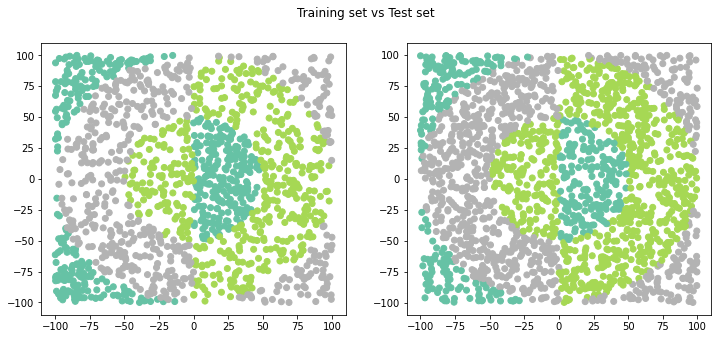

In [5]:
train_df = pd.read_csv("../dane/classification/rings3-regular-training.csv")
test_df = pd.read_csv("../dane/classification/rings3-regular-test.csv")

plot_train_test(train_df['x'], train_df['y'], train_df['c'], test_df['x'], test_df['y'], test_df['c'])

In [163]:
x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])

c = np.asarray(train_df['c'])
c_test = np.asarray(test_df['c'])

y_train = np.array(one_hot(c)).T

In [166]:
neurons = [2, 64, 64, 3]
mlp_softmax = MLP(neurons = neurons, activation_out='softmax')
mlp_softmax.learn_batch(x = x, y = y_train, learning_rate=0.012, iterations = 1000, batch_size=32)

mlp = MLP(neurons = neurons)
mlp.learn_batch(x = x, y = y_train, learning_rate=0.012, iterations = 1000, batch_size=32)

f-score: 
	without softmax: 0.7675
	with softmax: 0.8005


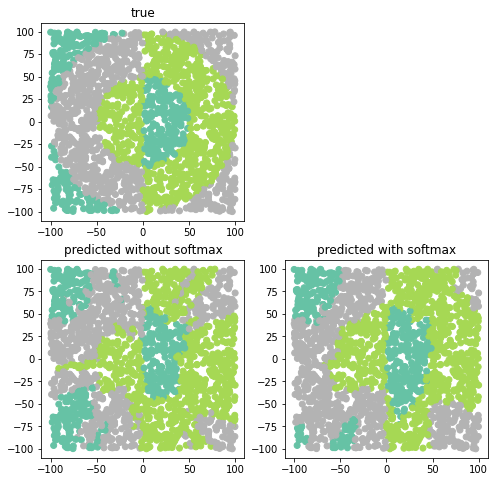

In [173]:
plot_compare_pred(test_df['x'], test_df['y'], test_df['c'], mlp.classify(x_test), mlp_softmax.classify(x_test))

## Drugi zbiór danych (*easy*)

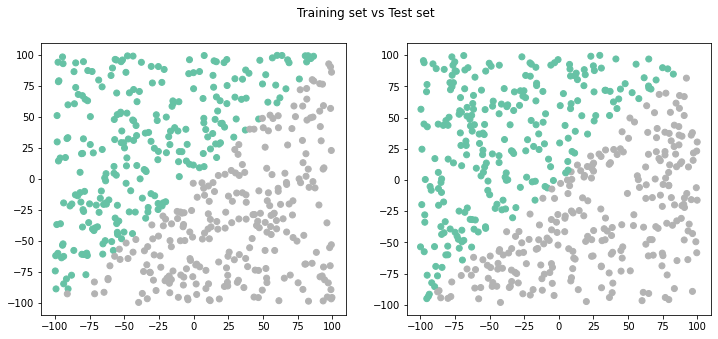

In [6]:
train_df = pd.read_csv('../dane/classification/easy-training.csv')
test_df = pd.read_csv('../dane/classification/easy-test.csv')

plot_train_test(train_df['x'], train_df['y'], train_df['c'], test_df['x'], test_df['y'], test_df['c'])

In [34]:
x_train = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])
y_train = np.asarray(train_df['c'])
y_test = np.asarray(test_df['c'])
y = np.array(one_hot(y_train)).T

neurons = [2, 20, 2]
mlp = MLP(neurons=neurons)

mlp_softmax = MLP(neurons=neurons, activation_out = 'softmax')
mlp_softmax.learn_batch(x = x_train, y = y, learning_rate = 0.0001, iterations = 2000, method = "momentum", decay = 0.7)
mlp.learn_batch(x = x_train, y = y, learning_rate = 0.0001, iterations = 2000, method = "momentum", decay = 0.7)

f-score: 
	without softmax: 0.998
	with softmax: 0.998


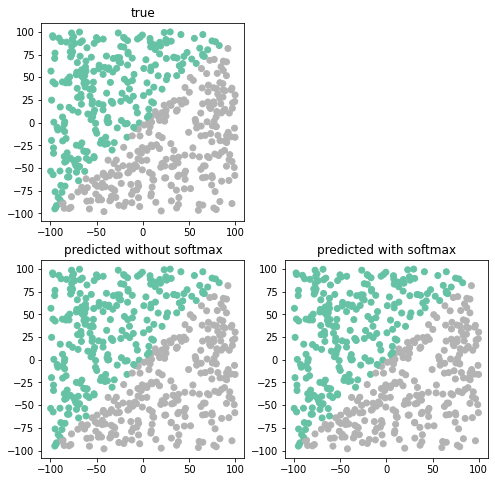

In [35]:
plot_compare_pred(test_df['x'], test_df['y'], test_df['c'], mlp.classify(x_test), mlp_softmax.classify(x_test))

## Trzeci zbiór danych (*xor3*)

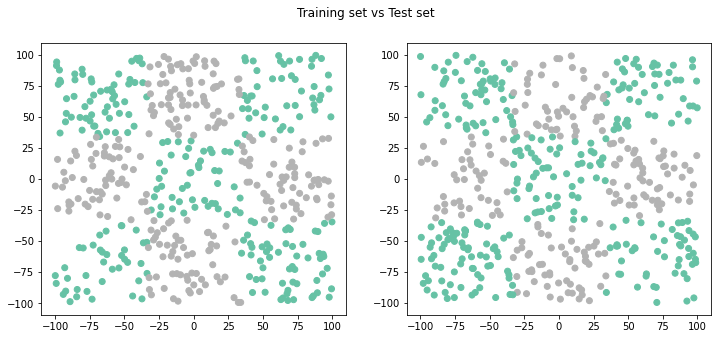

In [37]:
train_df = pd.read_csv('../dane/classification/xor3-training.csv')
test_df = pd.read_csv('../dane/classification/xor3-test.csv')

plot_train_test(train_df['x'], train_df['y'], train_df['c'], test_df['x'], test_df['y'], test_df['c'])

In [112]:
x_train = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])
y_train = np.asarray(train_df['c'])
y_test = np.asarray(test_df['c'])
y = np.array(one_hot(y_train)).T

neurons = [2, 128, 128, 128, 2]

mlp = MLP(neurons = neurons)
mlp.learn_batch(x = x_train, y = y, learning_rate = 0.001, iterations = 3000, method = "momentum", decay = 0.5)

mlp_softmax = MLP(neurons = neurons, activation_out = 'softmax')
mlp_softmax.learn_batch(x = x_train, y = y, learning_rate = 0.001, iterations = 3000, method = "momentum", decay = 0.5)

f-score: 
	without softmax: 0.8337236533957846
	with softmax: 0.8364485981308412


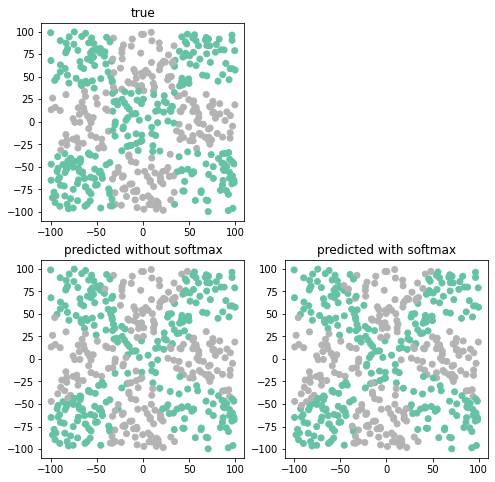

In [113]:
plot_compare_pred(test_df['x'], test_df['y'], test_df['c'], mlp.classify(x_test), mlp_softmax.classify(x_test))

## Podsumowując

| Dataset | No Softmax | Softmax |
|---------|------------|---------|
| Rings   | 0.7675     | 0.8005  |
| Easy    | 0.998      | 0.998   |
| XOR3    | 0.833      | 0.836   |

In [ ]:
print(f"f1 score = {f1_soft_test[-1]}")
print(f"CE score: = { cross_E(mlp_softmax.classify(x_test), y_test)}")

lr = 0.001
epochs = 100
prev_j
for j in range(prev_j200):
    mlp_softmax.learn_batch(x=x_train, y=y, learning_rate=lr, iterations=epochs, method="momentum", decay=0.65)
    f1_soft_train.append(f1_score(y_train, mlp_softmax.classify(x_train)))
    f1_soft_test.append(f1_score(y_test, mlp_softmax.classify(x_test)))
    print(f"epoch {epochs*j+epochs}, f1 score = {f1_soft_train[-1]}, CE score = { cross_E(mlp_softmax.classify(x_train), y_train)}\n")
    print(f"epoch {epochs*j+epochs}, f1 score = {f1_soft_test[-1]}, CE score = { cross_E(mlp_softmax.classify(x_test), y_test)}\n")
    if (1+j)%10 == 0:
        lr *= 0.5

f1 score = 0.07058823529411765
CE score: = 921.0340371967184
epoch 100, f1 score = 0.8181818181818181, CE score = 1243.3959501987847

epoch 200, f1 score = 0.8310502283105023, CE score = 1151.292546478823

epoch 300, f1 score = 0.8372093023255814, CE score = 1013.1374408993802

epoch 400, f1 score = 0.8394495412844037, CE score = 1082.2149936889016

epoch 500, f1 score = 0.8425925925925926, CE score = 1013.1374408991803

epoch 600, f1 score = 0.8445475638051045, CE score = 990.1115899692397

epoch 700, f1 score = 0.8384074941451989, CE score = 967.0857390395993

epoch 800, f1 score = 0.8438228438228438, CE score = 967.0857390393993

epoch 900, f1 score = 0.8484848484848485, CE score = 944.0598881093588

epoch 1000, f1 score = 0.8418604651162792, CE score = 990.1115899693398

epoch 1100, f1 score = 0.8430913348946136, CE score = 944.0598881095589

epoch 1200, f1 score = 0.8445475638051045, CE score = 990.1115899692397

epoch 1300, f1 score = 0.839907192575406, CE score = 1013.1374408992

KeyboardInterrupt: 

In [ ]:
print(f"f1 score = {f1_soft_test[-1]}")
print(f"CE score: = { cross_E(mlp_softmax.classify(x_test), y_test)}")

lr = 0.001
epochs = 100
prev_j
for j in range(prev_j200):
    mlp_softmax.learn_batch(x=x_train, y=y, learning_rate=lr, iterations=epochs, method="momentum", decay=0.65)
    f1_soft_train.append(f1_score(y_train, mlp_softmax.classify(x_train)))
    f1_soft_test.append(f1_score(y_test, mlp_softmax.classify(x_test)))
    print(f"epoch {epochs*j+epochs}, f1 score = {f1_soft_train[-1]}, CE score = { cross_E(mlp_softmax.classify(x_train), y_train)}\n")
    print(f"epoch {epochs*j+epochs}, f1 score = {f1_soft_test[-1]}, CE score = { cross_E(mlp_softmax.classify(x_test), y_test)}\n")
    if (1+j)%10 == 0:
        lr *= 0.5

f1 score = 0.07058823529411765
CE score: = 921.0340371967184
epoch 100, f1 score = 0.8181818181818181, CE score = 1243.3959501987847

epoch 200, f1 score = 0.8310502283105023, CE score = 1151.292546478823

epoch 300, f1 score = 0.8372093023255814, CE score = 1013.1374408993802

epoch 400, f1 score = 0.8394495412844037, CE score = 1082.2149936889016

epoch 500, f1 score = 0.8425925925925926, CE score = 1013.1374408991803

epoch 600, f1 score = 0.8445475638051045, CE score = 990.1115899692397

epoch 700, f1 score = 0.8384074941451989, CE score = 967.0857390395993

epoch 800, f1 score = 0.8438228438228438, CE score = 967.0857390393993

epoch 900, f1 score = 0.8484848484848485, CE score = 944.0598881093588

epoch 1000, f1 score = 0.8418604651162792, CE score = 990.1115899693398

epoch 1100, f1 score = 0.8430913348946136, CE score = 944.0598881095589

epoch 1200, f1 score = 0.8445475638051045, CE score = 990.1115899692397

epoch 1300, f1 score = 0.839907192575406, CE score = 1013.1374408992

KeyboardInterrupt: 

In [ ]:
print(f"f1 score = {f1_soft_test[-1]}")
print(f"CE score: = { cross_E(mlp_softmax.classify(x_test), y_test)}")

lr = 0.001
epochs = 100
prev_j
for j in range(prev_j200):
    mlp_softmax.learn_batch(x=x_train, y=y, learning_rate=lr, iterations=epochs, method="momentum", decay=0.65)
    f1_soft_train.append(f1_score(y_train, mlp_softmax.classify(x_train)))
    f1_soft_test.append(f1_score(y_test, mlp_softmax.classify(x_test)))
    print(f"epoch {epochs*j+epochs}, f1 score = {f1_soft_train[-1]}, CE score = { cross_E(mlp_softmax.classify(x_train), y_train)}\n")
    print(f"epoch {epochs*j+epochs}, f1 score = {f1_soft_test[-1]}, CE score = { cross_E(mlp_softmax.classify(x_test), y_test)}\n")
    if (1+j)%10 == 0:
        lr *= 0.5

f1 score = 0.07058823529411765
CE score: = 921.0340371967184
epoch 100, f1 score = 0.8181818181818181, CE score = 1243.3959501987847

epoch 200, f1 score = 0.8310502283105023, CE score = 1151.292546478823

epoch 300, f1 score = 0.8372093023255814, CE score = 1013.1374408993802

epoch 400, f1 score = 0.8394495412844037, CE score = 1082.2149936889016

epoch 500, f1 score = 0.8425925925925926, CE score = 1013.1374408991803

epoch 600, f1 score = 0.8445475638051045, CE score = 990.1115899692397

epoch 700, f1 score = 0.8384074941451989, CE score = 967.0857390395993

epoch 800, f1 score = 0.8438228438228438, CE score = 967.0857390393993

epoch 900, f1 score = 0.8484848484848485, CE score = 944.0598881093588

epoch 1000, f1 score = 0.8418604651162792, CE score = 990.1115899693398

epoch 1100, f1 score = 0.8430913348946136, CE score = 944.0598881095589

epoch 1200, f1 score = 0.8445475638051045, CE score = 990.1115899692397

epoch 1300, f1 score = 0.839907192575406, CE score = 1013.1374408992

KeyboardInterrupt: 

In [ ]:
print(f"f1 score = {f1_soft_test[-1]}")
print(f"CE score: = { cross_E(mlp_softmax.classify(x_test), y_test)}")

lr = 0.001
epochs = 100
prev_j
for j in range(prev_j200):
    mlp_softmax.learn_batch(x=x_train, y=y, learning_rate=lr, iterations=epochs, method="momentum", decay=0.65)
    f1_soft_train.append(f1_score(y_train, mlp_softmax.classify(x_train)))
    f1_soft_test.append(f1_score(y_test, mlp_softmax.classify(x_test)))
    print(f"epoch {epochs*j+epochs}, f1 score = {f1_soft_train[-1]}, CE score = { cross_E(mlp_softmax.classify(x_train), y_train)}\n")
    print(f"epoch {epochs*j+epochs}, f1 score = {f1_soft_test[-1]}, CE score = { cross_E(mlp_softmax.classify(x_test), y_test)}\n")
    if (1+j)%10 == 0:
        lr *= 0.5

f1 score = 0.07058823529411765
CE score: = 921.0340371967184
epoch 100, f1 score = 0.8181818181818181, CE score = 1243.3959501987847

epoch 200, f1 score = 0.8310502283105023, CE score = 1151.292546478823

epoch 300, f1 score = 0.8372093023255814, CE score = 1013.1374408993802

epoch 400, f1 score = 0.8394495412844037, CE score = 1082.2149936889016

epoch 500, f1 score = 0.8425925925925926, CE score = 1013.1374408991803

epoch 600, f1 score = 0.8445475638051045, CE score = 990.1115899692397

epoch 700, f1 score = 0.8384074941451989, CE score = 967.0857390395993

epoch 800, f1 score = 0.8438228438228438, CE score = 967.0857390393993

epoch 900, f1 score = 0.8484848484848485, CE score = 944.0598881093588

epoch 1000, f1 score = 0.8418604651162792, CE score = 990.1115899693398

epoch 1100, f1 score = 0.8430913348946136, CE score = 944.0598881095589

epoch 1200, f1 score = 0.8445475638051045, CE score = 990.1115899692397

epoch 1300, f1 score = 0.839907192575406, CE score = 1013.1374408992

KeyboardInterrupt: 

In [114]:
neurons = [2, 512, 512, 2]
mlp = MLP(neurons=neurons)
mlp_softmax = MLP(neurons=neurons, activation_out='softmax')

f1_train = []
f1_test = []
f1_soft_train = []
f1_soft_test = []

f1_train.append(f1_score(y_train, mlp.classify(x_train)))
f1_test.append(f1_score(y_test, mlp.classify(x_test)))
f1_soft_train.append(f1_score(y_train, mlp_softmax.classify(x_train)))
f1_soft_test.append(f1_score(y_test, mlp_softmax.classify(x_test)))

In [126]:
print(f"f1 score: train = {f1_soft_train[-1]}, test = {f1_soft_test[-1]}")
print(f"CE score: train = {cross_E(mlp_softmax.classify(x_train), y_train)}, test = { cross_E(mlp_softmax.classify(x_test), y_test)}")


lr = 0.001
epochs = 100

for i in range(4):
    for j in range(10):
        mlp_softmax.learn_batch(x=x_train, y=y, learning_rate=lr, iterations=epochs, method="momentum", decay=0.65)
        f1_soft_train.append(f1_score(y_train, mlp_softmax.classify(x_train)))
        f1_soft_test.append(f1_score(y_test, mlp_softmax.classify(x_test)))
        print(f"epoch {(10*i+j+1)*epochs}")
        print(f"f1 score: train = {f1_soft_train[-1]}, test = {f1_soft_test[-1]}")
        print(f"CE score: train = {cross_E(mlp_softmax.classify(x_train), y_train)}, test = { cross_E(mlp_softmax.classify(x_test), y_test)}\n")
    lr /= 5

f1 score: train = 0.9308943089430894, test = 0.8438228438228438
CE score: train = 299.33606206622596, test = 874.9823353198376
epoch 100
f1 score: train = 0.9371196754563895, test = 0.8477751756440282
CE score: train = 276.31021113618544, test = 921.0340371795185

epoch 200
f1 score: train = 0.944, test = 0.8367816091954023
CE score: train = 322.3619129955664, test = 1082.2149936890016

epoch 300
f1 score: train = 0.945010183299389, test = 0.8544600938967137
CE score: train = 207.23265834626415, test = 874.9823353195375

epoch 400
f1 score: train = 0.9498997995991985, test = 0.8511627906976744
CE score: train = 276.31021113558546, test = 944.0598881092588

epoch 500
f1 score: train = 0.9494949494949495, test = 0.8571428571428572
CE score: train = 230.25850927590457, test = 874.9823353194374

epoch 600
f1 score: train = 0.9556451612903225, test = 0.8544600938967137
CE score: train = 207.23265834576412, test = 874.9823353195375

epoch 700
f1 score: train = 0.9508196721311476, test = 0.85

In [ ]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(20, 14)
ax[0, 0].plot(list(range(len(f1_train))), f1_train, markerfacecolor = 'm', markersize=3, marker='o')
ax[0, 0].plot(list(range(len(f1_train))), f1_test, markerfacecolor = 'm', marker='^', markersize=3)
ax[0, 0].set_title("no softmax")
ax[0, 0].vlines([list(range(0, 5*20, 20))], 0, 1)
plt.legend(['train', 'test'])

ax[0, 1].plot(list(range(len(f1_soft_train))), f1_soft_train, markerfacecolor = 'c', markersize=3, marker='o')
ax[0, 1].plot(list(range(len(f1_soft_test))), f1_soft_test, markerfacecolor = 'c', markersize=3, marker='^')
ax[0, 1].set_title("softmax")
ax[0, 1].vlines([list(range(0, 5*20, 20))], 0, 1)
plt.legend(['train', 'test'])

ax[1, 0].plot(list(range(len(f1_train))), f1_train, markerfacecolor = 'm', markersize=3, marker='o')
ax[1, 0].plot(list(range(len(f1_train))), f1_soft_train, markerfacecolor = 'c', markersize=3, marker='o')
ax[1, 0].set_title("train")
ax[1, 0].vlines([list(range(0, 5*20, 20))], 0, 1)
plt.legend(['no softmax', 'softmax'])

ax[1, 1].plot(list(range(len(f1_train))), f1_test,markerfacecolor = 'm', markersize=3, marker='^')
ax[1, 1].plot(list(range(len(f1_train))), f1_soft_test, markerfacecolor = 'c', markersize=3, marker='^')
ax[1, 1].set_title("test")
ax[1, 1].vlines([list(range(0, 5*20, 20))], 0, 1)
plt.legend(['no softmax', 'softmax'])

In [ ]:
plot_compare_pred(test_df['x'], test_df['y'], test_df['c'], mlp.classify(x_test), mlp_softmax.classify(x_test))

In [ ]:
neurons = [2,128, 128, 128, 128, 2]
mlp = MLP(neurons=neurons)
mlp_softmax = MLP(neurons=neurons, activation_out='softmax')

f1_train = []
f1_test = []
f1_soft_train = []
f1_soft_test = []

f1_train.append(f1_score(y_train, mlp.classify(x_train)))
f1_test.append(f1_score(y_test, mlp.classify(x_test)))
f1_soft_train.append(f1_score(y_train, mlp_softmax.classify(x_train)))
f1_soft_test.append(f1_score(y_test, mlp_softmax.classify(x_test)))

In [ ]:
print(f"f1 score: no soft = {f1_test[-1]}, soft = {f1_soft_test[-1]}")
print(f"CE score: no soft = {cross_E(mlp.classify(x_test), y_test)}, soft = { cross_E(mlp_softmax.classify(x_test), y_test)}")


lr = 0.0001
epochs = 100


for j in range(20):
    for i in range(20):
        mlp_softmax.learn_batch(x=x_train, y=y, learning_rate=lr, iterations=epochs, method="momentum", decay=0.65)
        mlp.learn_batch(x=x_train, y=y, learning_rate=lr, iterations=epochs, method="momentum", decay=0.65)
        f1_train.append(f1_score(y_train, mlp.classify(x_train)))
        f1_test.append(f1_score(y_test, mlp.classify(x_test)))
        f1_soft_train.append(f1_score(y_train, mlp_softmax.classify(x_train)))
        f1_soft_test.append(f1_score(y_test, mlp_softmax.classify(x_test)))
        print(f"epoch {(20*j+i+1)*epochs}")
        print(f"f1 score: no soft = {f1_test[-1]}, soft = {f1_soft_test[-1]}")
        print(f"CE score: no soft = {cross_E(mlp.classify(x_test), y_test)}, soft = { cross_E(mlp_softmax.classify(x_test), y_test)}\n")
    lr*=0.8


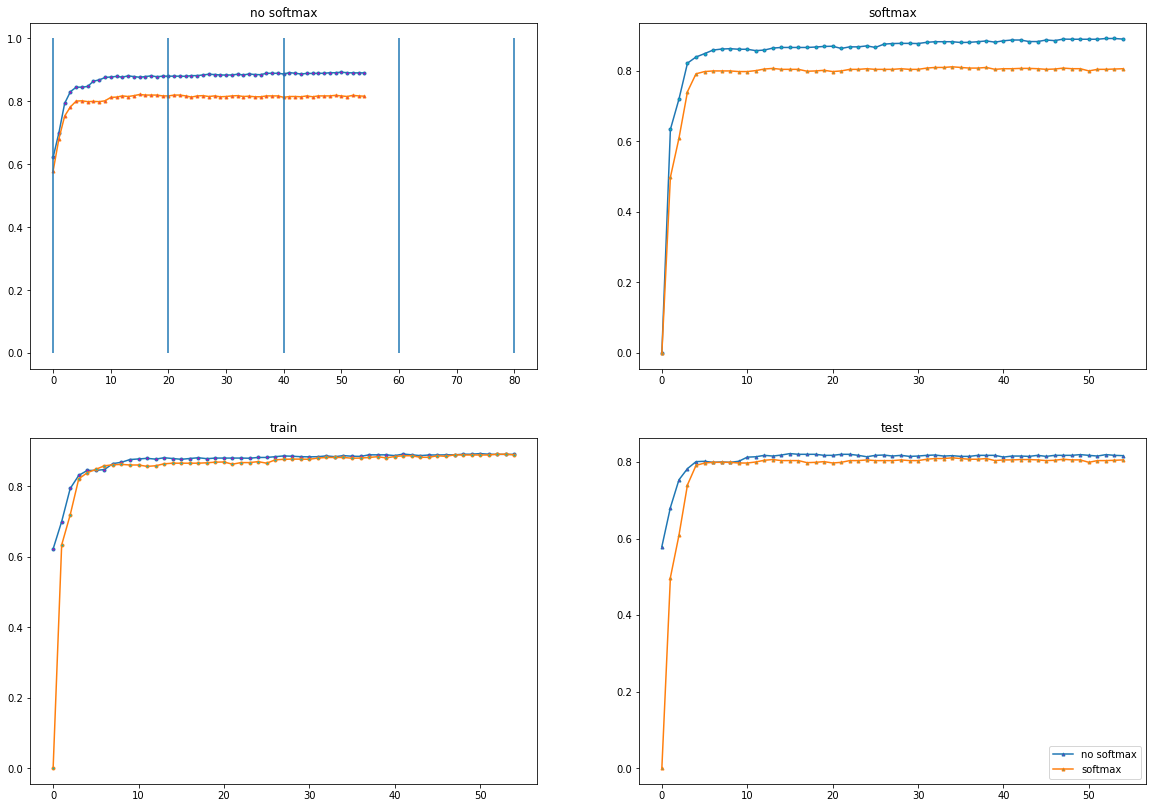

In [101]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(20, 14)
ax[0, 0].plot(list(range(len(f1_train))), f1_train, markerfacecolor = 'm', markersize=3, marker='o')
ax[0, 0].plot(list(range(len(f1_train))), f1_test, markerfacecolor = 'm', marker='^', markersize=3)
ax[0, 0].set_title("no softmax")
ax[0, 0].vlines([list(range(0, 5*20, 20))], 0, 1)
plt.legend(['train', 'test'])

ax[0, 1].plot(list(range(len(f1_soft_train))), f1_soft_train, markerfacecolor = 'c', markersize=3, marker='o')
ax[0, 1].plot(list(range(len(f1_soft_test))), f1_soft_test, markerfacecolor = 'c', markersize=3, marker='^')
ax[0, 1].set_title("softmax")
ax[0, 1].vlines([list(range(0, 5*20, 20))], 0, 1)
plt.legend(['train', 'test'])

ax[1, 0].plot(list(range(len(f1_train))), f1_train, markerfacecolor = 'm', markersize=3, marker='o')
ax[1, 0].plot(list(range(len(f1_train))), f1_soft_train, markerfacecolor = 'c', markersize=3, marker='o')
ax[1, 0].set_title("train")
ax[1, 0].vlines([list(range(0, 5*20, 20))], 0, 1)
plt.legend(['no softmax', 'softmax'])

ax[1, 1].plot(list(range(len(f1_train))), f1_test,markerfacecolor = 'm', markersize=3, marker='^')
ax[1, 1].plot(list(range(len(f1_train))), f1_soft_test, markerfacecolor = 'c', markersize=3, marker='^')
ax[1, 1].set_title("test")
ax[1, 1].vlines([list(range(0, 5*20, 20))], 0, 1)
plt.legend(['no softmax', 'softmax'])

f-score: 
	without softmax: 0.8165137614678899
	with softmax: 0.8053691275167785


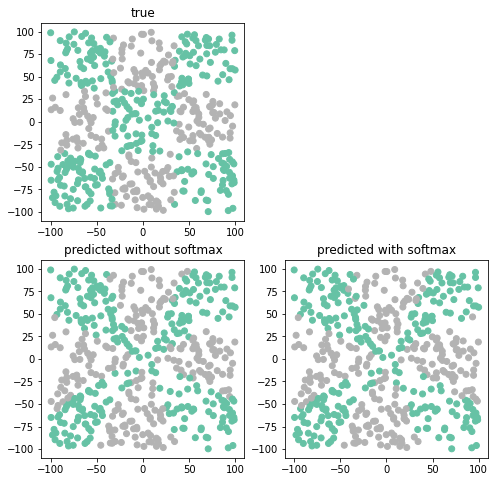

In [97]:
plot_compare_pred(test_df['x'], test_df['y'], test_df['c'], mlp.classify(x_test), mlp_softmax.classify(x_test))